In [ ]:
# fname_test = "/data/user/navidkrad/hdf/cascades_v0.6_CscdSBU_BDT//sim/IceCube/2020/CORSIKA-in-ice/20904/test_train/test.hdf5"
# fname_train = "/data/user/navidkrad/hdf/cascades_v0.6_CscdSBU_BDT//sim/IceCube/2020/CORSIKA-in-ice/20904/test_train/train.hdf5"

fname_train = "/lustre/fs23/group/icecube/nrad/data/hdf/Cscd_v0.0.2_mupos/sim/IceCube/2020/CORSIKA-in-ice/20904/test_train/train.hdf5"
fname_test = "/lustre/fs23/group/icecube/nrad/data/hdf/Cscd_v0.0.2_mupos/sim/IceCube/2020/CORSIKA-in-ice/20904/test_train/test.hdf5"

fname = fname_train


import sys
sys.path.append("../")
import utils

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from utils import *
import plothist as ph
import tensorflow as tf


df_train = pd.read_hdf(fname_train)
df_test = pd.read_hdf(fname_test)
# dfs = [df_train, df_test]
dfs = [df_test]
df_corsika  = pd.concat(dfs)

zzSBU_dir = "/lustre/fs23/group/icecube/nrad/data/zzSBU/"


/cephfs/users/nrad/work/i3kiss/notebooks/../utils/__init__.py:1: UserWarning: The recommended fonts to use plothist were not found. You can install them by typing 'install_latin_modern_fonts' in your terminal. If it still does not work, please check the documentation at https://plothist.readthedocs.io/en/latest/usage/font_installation.html
  from utils.plotting_utils import *
2025-01-17 13:19:25.590269: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 13:19:25.614093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-17 13:19:25.631521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN 

In [3]:
#[k for k in df.columns if 'weight' in k]

k = 'gen_weights_squared_balanced'
k = 'balanced_weights_squared'
# k = 'balanced_weights'

l = 'CscdBDT'

df = df_test

cls0 = df[l] == 0 
cls1 = df[l] == 1

df[cls0][k].sum() / df[cls1][k].sum()



0.9999999999999997

## Setup samples and define functions

### Load CscdSBU samples

In [4]:
## Samples setup

import pandas as pd

# filename_dir = "/home/navidkrad/work/zzSBU/event_selection/hdf/"
filename_dir = "/lustre/fs23/group/icecube/nrad/data/zzSBU/event_selection/hdf/"
filename_muongun = os.path.join(filename_dir, "21315-21319_final_all.h5")
filename_data = os.path.join(filename_dir, "IC86_2010-2020_final_all_burn.h5")


keys = ['cscdSBU_MuonWeight_GaisserH4a']
keys = ['cscdSBU_L4VetoTrack_cscdSBU_MonopodFit4_noDCVetoCharge', 'cscdSBU_MonopodFit4', 'cscdSBU_I3XYScale_noDC']
keys += ['cscdSBU_LE_bdt_cascade',
        'cscdSBU_LE_bdt_hybrid',
        'cscdSBU_LE_bdt_track',
        'cscdSBU_LE_bdt_input',
        'cscdSBU_LE_tags',
        'cscdSBU_Qtot_HLC',
]


nugen_simids = [21813,21814,21867,21868,21870,21871]
nugen_weight_keys = [
    "I3MCWeightDict",
    "mceq_HillasGaisser2012_H4a_CORSIKA_SouthPole_December_SIBYLL2.3c_conv",
    "mceq_HillasGaisser2012_H4a_CORSIKA_SouthPole_June_SIBYLL2.3c_conv",
    "cscdSBU_HillasGaisser2012_H4a_CORSIKA_SouthPole_December_SIBYLL2.3c_conv_step1000_passing_rate",
    "mceq_HillasGaisser2012_H4a_CORSIKA_SouthPole_December_SIBYLL2.3c_pr",
    "mceq_HillasGaisser2012_H4a_CORSIKA_SouthPole_June_SIBYLL2.3c_pr",
    "cscdSBU_HillasGaisser2012_H4a_CORSIKA_SouthPole_December_SIBYLL2.3c_pr_step1000_passing_rate"
]

key_column_dict = {"I3MCWeightDict": ["PrimaryNeutrinoEnergy", "NEvents", "OneWeight"]}



In [5]:
def read_hdf_multiple_datasets(filename, keys=None, key_column_dict={}):
    """
    Read multiple datasets from a single HDF5 file and return them as a single dataframe.
    The function reads all keys in the file if keys is None.
    The function also renames the 'value' column to the key name.
    
    """
    cols_to_ignore = ['Run', 'Event', 'SubEvent', 'SubEventStream', 'exists']

    with pd.HDFStore(filename, mode='r') as store:
        store_keys = [k.lstrip("/") for k in store.keys()]
        if keys is None:
            keys = store_keys
            print("Will read all keys: %s"%keys)
        else:
            for k in keys:
                if k not in store_keys:
                    print("Key %s not found in the file. Ignoring it."%k)
                    keys.remove(k)

        dfs = []
        found_run_info = False

        for ikey, store_key in enumerate(keys):
            key = store_key.lstrip("/")
            df = store[store_key]
            if key in key_column_dict:
                df = df[key_column_dict[key]]
            
            # Ignore specified columns if they exist
            # print(ikey, store_key, df.columns, found_run_info)
            if not found_run_info:
                if all([col in df.columns for col in cols_to_ignore]):
                    found_run_info = True
            else:
                df = df.drop(columns=[col for col in cols_to_ignore if col in df.columns])            
            # Rename 'value' column to the key name
            #if len(df.columns)==1 and 'value' in df.columns:
            if 'value' in df.columns:
                df = df.rename(columns={'value': key})
            # For other columns, combine key and column name to differentiate them
            df = df.rename(columns={col: f"{key}_{col}" for col in df.columns if (col != key) and (col not in cols_to_ignore) })
            dfs.append(df)
        
    # Concatenate all dataframes along columns
    final_df = pd.concat(dfs, axis=1)
    return final_df


##
## Nugen setup
##

nugen_nfiles = {
        21813:9998,
        21814:9998,
        21867:100,
        21868:100,
        21870:100,
        21871:100,
        21938:99,
        21939:100,
        21940:96,
    }



def add_nugen_weights(df, nfiles):
    nu_fit_params = dict(
        astro_norm = 1.58,
        astro_index = -2.53,
        conv_norm = 1.02,
        pr_norm = 0,
    )

    def get_astro_w(df, **params):

        primary_energy = df["I3MCWeightDict_PrimaryNeutrinoEnergy"]
        one_weight = df["I3MCWeightDict_OneWeight"]
        nevents = df["I3MCWeightDict_NEvents"]

        astro_index = params.get("astro_index", nu_fit_params["astro_index"])
        astro_norm = params.get("astro_norm", nu_fit_params["astro_norm"])
        ltime = params.get("ltime", 1)
        nfiles = params.get("nfiles", )

        flux = astro_norm * 10**(-18) * np.power(primary_energy / 100000, astro_index) * ltime
        return flux * one_weight / (nevents * nfiles)

    def get_conv_w(df, **params):
        one_weight = df["I3MCWeightDict_OneWeight"]
        nevents = df["I3MCWeightDict_NEvents"]

        conv_dec = df["mceq_HillasGaisser2012_H4a_CORSIKA_SouthPole_December_SIBYLL2.3c_conv"]
        conv_jun = df["mceq_HillasGaisser2012_H4a_CORSIKA_SouthPole_June_SIBYLL2.3c_conv"]
        conv_weight = (conv_dec + conv_jun)/2
        conv_passrate = df["cscdSBU_HillasGaisser2012_H4a_CORSIKA_SouthPole_December_SIBYLL2.3c_conv_step1000_passing_rate"]

        conv_norm = params.get("conv_norm", nu_fit_params["conv_norm"])        
        ltime = params.get("ltime", 1)
        nfiles = params.get("nfiles", )

        return one_weight * 2 / (nevents * nfiles) * conv_norm * conv_weight * conv_passrate * ltime

    def get_pr_w(df, **params):
        one_weight = df["I3MCWeightDict_OneWeight"]
        nevents = df["I3MCWeightDict_NEvents"]

        pr_dec = df["mceq_HillasGaisser2012_H4a_CORSIKA_SouthPole_December_SIBYLL2.3c_pr"]
        pr_jun = df["mceq_HillasGaisser2012_H4a_CORSIKA_SouthPole_June_SIBYLL2.3c_pr"]
        prompt_weight = (pr_dec+pr_jun)/2
        prompt_passrate = df["cscdSBU_HillasGaisser2012_H4a_CORSIKA_SouthPole_December_SIBYLL2.3c_pr_step1000_passing_rate"]

        prompt_norm = params.get("pr_norm", nu_fit_params["pr_norm"])
        ltime = params.get("ltime", 1)
        nfiles = params.get("nfiles", )
        return one_weight * 2 / (nevents * nfiles) * prompt_norm * prompt_weight * prompt_passrate * ltime

    # df['final_astro_w'] = get_astro_w(df['I3MCWeightDict_PrimaryNeutrinoEnergy'], df['I3MCWeightDict_OneWeight'], df['I3MCWeightDict_NEvents'], nfiles)
    # df['final_conv_w'] = get_conv_w(df['I3MCWeightDict_OneWeight'], df['conv_value'], df['conv_passrate_value'], df['I3MCWeightDict_NEvents'], nfiles)
    # df['final_pr_w'] = get_pr_w(df['I3MCWeightDict_OneWeight'], df['pr_value'], df['pr_passrate_value'], df['I3MCWeightDict_NEvents'], nfiles)

    df['weights_astro'] = get_astro_w(df, nfiles=nfiles, **nu_fit_params)
    df['weights_conv'] = get_conv_w(df, nfiles=nfiles, **nu_fit_params)
    df['weights_prompt'] = get_pr_w(df, nfiles=nfiles, **nu_fit_params)


##
## Data
##

def get_livetime(year,bb="burn"):
    #grl_dir = "/Users/zhang/Google Drive/studyAndWork/IceCube/pass2_GlobalFit/good_run_list/"
    # https://wiki.icecube.wisc.edu/index.php/Pass2_Multi_Year_Cascade_Analysis#Good_Run_List
    grl_dir = f"{zzSBU_dir}/good_run_list/"
    grls = glob.glob(grl_dir+f"*{year}*.txt")
    grl = grls[0]
    df = pd.read_csv(grl,sep="\s+",usecols=[0,1,2,3],skiprows=[1],index_col=False)
    if bb=="burn":
        cut = df["RunNum"]%10==0
    elif bb == "blind":
        cut = ~(df["RunNum"]%10==0)
    elif bb == "all":
        cut = np.ones_like(df["RunNum"])
    else:
        print("wrong bb settings")
        return False
    livetime = df["LiveTime(s)"][cut].sum()
    return livetime

def get_pass2_ltime():
    ltime_pass2_burn = 0
    for year in range(2010,2021):
        #print(f'{year = }')
        ltime_pass2_burn += get_livetime(year,"burn")
    #for year in range(2011,2021):
    #    ltime_pass2_burn += get_livetime(year,"all")
    print(f'{ltime_pass2_burn = }')
    return ltime_pass2_burn

def apply_sel(df, ):
    df = df.query("cos(cscdSBU_MonopodFit4_zenith)<1 & cos(cscdSBU_MonopodFit4_zenith)>-1")
    df = df.query("cscdSBU_MonopodFit4_z<1000 & cscdSBU_MonopodFit4_z>-1000")
    # energy_max=10**4,energy_min=0
    df = df.query("cscdSBU_MonopodFit4_energy<1E6 & cscdSBU_MonopodFit4_energy>0")
    return df

pass2_livetime = get_pass2_ltime()


ltime_pass2_burn = 32715420.04


In [6]:
## 
## Get Nugen Samples
##

df_nugen = {}
for simid in nugen_simids:
    # filename = f"/home/navidkrad/work/zzSBU/event_selection/hdf/{simid}_all.h5"
    filename = os.path.join(filename_dir, f"{simid}_all.h5")
    if os.path.exists(filename):
        #summary[simid]=get_nugen(simid,sel="all")
        df_nugen[simid] = read_hdf_multiple_datasets(filename, keys=keys+nugen_weight_keys,
            key_column_dict=key_column_dict
        )
        add_nugen_weights(df_nugen[simid], nfiles=nugen_nfiles[simid])
    else:
        print(f"File {filename} does not exist.")

df_nugen_all = pd.concat(df_nugen.values())

In [7]:
## 
## Get Data
##

df_data = read_hdf_multiple_datasets(filename_data, keys=keys)
df_data = apply_sel(df_data)
df_data['weights'] = 1.0/pass2_livetime


In [8]:
##
## Get MuonGun
##

weight_col = 'cscdSBU_MuonWeight_GaisserH4a'

df_mugun = read_hdf_multiple_datasets(filename_muongun, keys=keys+[weight_col])

mugun_nfile_factor = {
        21315:15000/5000,
        21316:39995/5000,
        21317:19994/5000,
        21318:99975/5000,
        21319:99636/5000,
        }

nfile_factor_df = df_mugun["Run"].map(mugun_nfile_factor)
df_mugun['weights'] = df_mugun[weight_col]
df_mugun['weights'] *= 1.42/nfile_factor_df


AttributeError: 'function' object has no attribute 'glob'

### Other functions

In [50]:


def plt_subplots(**kwargs):
    # plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace':0.05})
    kwargs.setdefault('figsize', (6, 5))
    kwargs.setdefault('sharex', True)
    kwargs.setdefault('height_ratios', [3, 1])
    #kwargs.setdefault('hspace', 0.05)
    kwargs.setdefault('gridspec_kw', {})
    #kwargs['gridspec_kw'].setdefault('height_ratios', [3, 1])
    kwargs['gridspec_kw'].setdefault('hspace', 0.05)
    kwargs.setdefault('nrows', 2)
    kwargs.setdefault('ncols', 1)  
    print(kwargs)
    fig, axs = plt.subplots(**kwargs)
    return fig, axs


def fom_func_naive_sig(s_uarray, b_uarray):
    return np.sum(s_uarray)/np.sum(b_uarray).std_dev

def calc_fom(h_sig, h_bkg, per_bin=False, fom_func=fom_func_naive_sig):
    sig_values = h_sig.values()
    bkg_uncerts = np.sqrt(h_bkg.variances())
    bkg_values = h_bkg.values()
    if per_bin:
        fom_values = sig_values/bkg_uncerts
    else:
        from uncertainties import unumpy
        bkg = unumpy.uarray(bkg_values, bkg_uncerts )
        bkg = np.where(bkg==0, np.nan, bkg)

        fom_values = []
        for ibin in range(len(bkg)):
            # fom = np.sum(sig_values[ibin:])/np.sum(bkg[ibin:]).std_dev
            fom = fom_func(sig_values[ibin:], bkg[ibin:])
            fom_values.append(fom)
            #fom_values
        
    return fom_values

def calc_ZA(s, b, sigma_b=0):
    if sigma_b == 0:
        return np.sqrt( 2*( (s+b)*np.log(1+s/b) - s) )
    else:
        return np.sqrt( 2*( (s+b)*np.log( (s+b)*(b+sigma_b**2)/(b**2 + (s+b)*sigma_b**2) ) - (b**2/sigma_b**2)*np.log(1+sigma_b**2*s/(b*(b*sigma_b**2))) ))   
    


def calc_Za(h_sig, h_bkg, per_bin=False):
    sig_values = h_sig.values()
    bkg_uncerts = np.sqrt(h_bkg.variances())
    bkg_values = h_bkg.values()
    if per_bin:
        zn_values = sig_values/np.sqrt(bkg_values)
    else:
        from uncertainties import unumpy
        bkg = unumpy.uarray(bkg_values, bkg_uncerts )
        bkg = np.where(bkg==0, np.nan, bkg)

        zn_values = []
        for ibin in range(len(bkg)):
            zn = np.sum(sig_values[ibin:])/np.sqrt(np.sum(bkg[ibin:]).std_dev)
            zn_values.append(zn)
            #fom_values
        
    return zn_values

def get_cpu_estimate(df, n_photons_col='n_photons', weight_cols=['sel_gen_weights'], time_per_photon=None):
    n_photons = df['n_photons']
    weights = utils.combine_weight_columns(df, weight_cols)
    return np.sum(n_photons*weights)

def get_cpu_hist(df, var, bins, n_photons_col='n_photons', weight_cols=['sel_gen_weights']):
    h = make_hist(df[var], bins=bins)
    edges = h.axes[0].edges

    values = []
    print(edges)
    for edge in edges[:-1]:
        df_ = df.query(f'{var}>{edge}')
        cpu = get_cpu_estimate(df_, n_photons_col=n_photons_col, weight_cols=weight_cols)
        values.append(cpu)
        print(edge, cpu)

    return h,values



# h, values = get_cpu_hist(df, 'pred', bins=np.linspace(0,1,100))



In [81]:
utils.make_hist

<function plothist.histogramming.make_hist(data=array([], dtype=float64), bins=50, range=None, weights=1)>

# Get Histograms

In [11]:


# var_name = 'monopod_coszenith'
# var_name = "hybrid_score"
# var_name = 'monopod_energy'

# var_info = variables[var_name]
# var = var_info['var']
# bins = var_info['bins']

# hists = {}

# for sname, info in samples.items():
#     df = info['df']
#     # df = apply_sel(df)
#     weights = df[info['weights']] if info.get('weights') else None
#     h = make_hist(df[var], weights=weights, bins=bins)
#     hists[sname] = h





{'figsize': (6, 5), 'sharex': True, 'height_ratios': [3, 1], 'gridspec_kw': {'hspace': 0.05}, 'nrows': 2, 'ncols': 1}
{'dpi': 100, 'bbox_inches': 'tight'}
plot saved in: /afs/ifh.de/user/n/nrad/www/plots/Cscd_v0.0.2_mupos/muemb_v0.0/base_v0.0/monopod_energy_coarse.png
directory /afs/ifh.de/user/n/nrad/www/plots/Cscd_v0.0.2_mupos/muemb_v0.0/base_v0.0/monopod_energy_coarse.png --> 
https://www-zeuthen.desy.de/~nrad/plots/Cscd_v0.0.2_mupos/muemb_v0.0/base_v0.0/monopod_energy_coarse.png


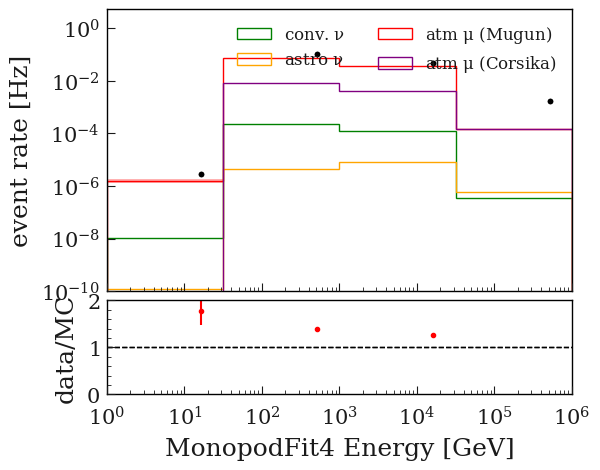

In [65]:

plot_dir = "/data/user/navidkrad/plots/cascades_v0.6_CscdSBU_PreBDT/CscdPreBDT_allfeat_w2_v3/plots/"
plot_dir = "/afs/ifh.de/user/n/nrad/www/plots/Cscd_v0.0.2_mupos/muemb_v0.0/base_v0.0/"

variables_names = ['monopod_energy_coarse']

for var_name in variables_names:
    res = get_hist_and_plot(**variables[var_name],
                            plot_path=os.path.join(plot_dir, f"{var_name}.png")
                            )
    


In [14]:

# 
# samples['mugun']['weights']
# 


/home/navidkrad/.local/lib/python3.11/site-packages/plothist/histogramming.py:115: UserWarning: Only 83.08% of data contained in the binning range [1e-05, 0.3). Note that the upper edge is exclusive.
  warnings.warn(
/home/navidkrad/.local/lib/python3.11/site-packages/plothist/histogramming.py:115: UserWarning: Only 72.52% of data contained in the binning range [1e-05, 0.3). Note that the upper edge is exclusive.
  warnings.warn(
/home/navidkrad/.local/lib/python3.11/site-packages/plothist/histogramming.py:115: UserWarning: Only 53.76% of data contained in the binning range [1e-05, 0.3). Note that the upper edge is exclusive.
  warnings.warn(


{'figsize': (6, 5), 'sharex': True, 'height_ratios': [3, 1], 'gridspec_kw': {'hspace': 0.05}, 'nrows': 2, 'ncols': 1}
{'dpi': 100, 'bbox_inches': 'tight'}
plot saved in: /data/user/navidkrad/plots/cascades_v0.6_CscdSBU_PreBDT/CscdPreBDT_allfeat_w2_v3/plots/VertexRecoDist_CscdLLh_zoom.png
directory /data/user/navidkrad/plots/cascades_v0.6_CscdSBU_PreBDT/CscdPreBDT_allfeat_w2_v3/plots/VertexRecoDist_CscdLLh_zoom.png --> 
https://convey.icecube.wisc.edu/data/user/navidkrad/plots/cascades_v0.6_CscdSBU_PreBDT/CscdPreBDT_allfeat_w2_v3/plots/VertexRecoDist_CscdLLh_zoom.png


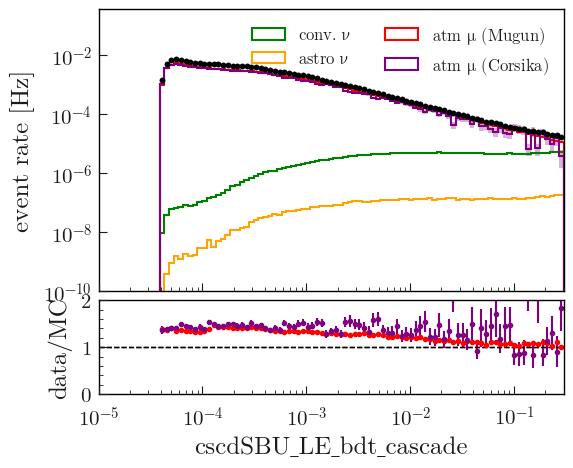

In [16]:

res = get_hist_and_plot(variables['cascade_score']['var'],
                        bins=np.geomspace(1E-5,0.3,100),
                        plot_path=os.path.join(plot_dir, f"{var_name}_zoom.png"),
                        xscale='log',
                        )


# Smart Sampling

In [71]:
hists['corsika']

Histogram(Variable(array([1.00000000e+00, 1.31825674e+00, 1.73780083e+00, 2.29086765e+00,
       3.01995172e+00, 3.98107171e+00, 5.24807460e+00, 6.91830971e+00,
       9.12010839e+00, 1.20226443e+01, 1.58489319e+01, 2.08929613e+01,
       2.75422870e+01, 3.63078055e+01, 4.78630092e+01, 6.30957344e+01,
       8.31763771e+01, 1.09647820e+02, 1.44543977e+02, 1.90546072e+02,
       2.51188643e+02, 3.31131121e+02, 4.36515832e+02, 5.75439937e+02,
       7.58577575e+02, 1.00000000e+03, 1.31825674e+03, 1.73780083e+03,
       2.29086765e+03, 3.01995172e+03, 3.98107171e+03, 5.24807460e+03,
       6.91830971e+03, 9.12010839e+03, 1.20226443e+04, 1.58489319e+04,
       2.08929613e+04, 2.75422870e+04, 3.63078055e+04, 4.78630092e+04,
       6.30957344e+04, 8.31763771e+04, 1.09647820e+05, 1.44543977e+05,
       1.90546072e+05, 2.51188643e+05, 3.31131121e+05, 4.36515832e+05,
       5.75439937e+05, 7.58577575e+05, 1.00000000e+06]), underflow=False, overflow=False), storage=Weight()) # Sum: WeightedSum(v

## load models

In [39]:
from utils import tf_utils
from ModelFactory import ModelFactory
from MuModelFactory import MuModelFactory

model_infos = [
    dict(version_tag='Cscd_v0.0.2_mupos', model_tag='simple_v0.0', model_name='base_large_v0.0'),
    dict(version_tag="Cscd_v0.0.2_mupos", model_tag="muemb_v0.0", model_name="base_1028_v0.0")

]

mfs = {}

df = samples['corsika']['df']
df = df_corsika


model_names = []

for model_info in model_infos:
    model_name = model_info['model_name']
    model_tag = model_info.get('model_tag', "")
    version_tag = model_info.get('version_tag', "")
    model_label = model_name + (f"_{model_tag}" if model_tag else "")
    print(model_info)
    if 'muemb' in model_tag:
        mf = MuModelFactory.load_model(model_name, model_tag=model_tag, version_tag=version_tag)
    else:
        mf = ModelFactory.load_model(model_name, model_tag=model_tag, version_tag=version_tag)
    mfs[model_label] = mf

    mf._df_test = df_test
    mf._df_train = df_train

    # df[model_label] = mf.model.predict(df[mf.features], batch_size=mf.batch_size)
    X = df[mf.features] if not hasattr(mf, "xy_maker") else mf.xy_maker(mf, df)['x']
    df[model_label] = mf.model.predict(X, batch_size=mf.batch_size) 
    print(model_name)
    model_names.append(model_label)



{'version_tag': 'Cscd_v0.0.2_mupos', 'model_tag': 'simple_v0.0', 'model_name': 'base_large_v0.0'}
loading model from:  /afs/ifh.de/user/n/nrad/lustre/i3kiss/models/Cscd_v0.0.2_mupos/simple_v0.0/base_large_v0.0/model.keras
define_flexible_model
<function define_flexible_model at 0x7f676199bce0>
MODEL <Sequential name=sequential, built=True>
loading weights from:  /afs/ifh.de/user/n/nrad/lustre/i3kiss/models/Cscd_v0.0.2_mupos/simple_v0.0/base_large_v0.0/base_large_v0.0.weights.h5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
base_large_v0.0
{'version_tag': 'Cscd_v0.0.2_mupos', 'model_tag': 'muemb_v0.0', 'model_name': 'base_1028_v0.0'}
loading model from:  /afs/ifh.de/user/n/nrad/lustre/i3kiss/models/Cscd_v0.0.2_mupos/muemb_v0.0/base_1028_v0.0/model.keras
define_muemb_model
<function define_muemb_model at 0x7f67619bdbc0>
MODEL <Functional name=CombinedModel, built=True>
loading weights from:  /afs/ifh.de/user/n/nrad/lustre/i3kiss/models/Cscd_v0.0.2_mupos/muemb_v0.0/base_1028_v0.0/base_1028_v0.0.

I0000 00:00:1737117420.804436 2568445 service.cc:146] XLA service 0xac5ee70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737117420.909256 2568445 service.cc:154]   StreamExecutor device (0): Host, Default Version
2025-01-17 13:37:02.827110: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737117429.009432 2568445 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step
base_1028_v0.0


In [41]:
mf.get_pred()

296/296 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [ ]:
mf.X_train



296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


array([[0.780444  ],
       [0.5708711 ],
       [0.78142   ],
       ...,
       [0.6587865 ],
       [0.47525254],
       [0.5569587 ]], dtype=float32)

In [42]:
from utils import speedup_utils
df = df_corsika
speedup_utils.add_pseudo_preds(df, truth_label='CscdBDT')

pseudo_preds = [k for k in df.columns if 'pseudo_pred' in k]
pseudo_preds = ['pseudo_pred_gauss', 'pseudo_pred_uniform']
print(f"{pseudo_preds = }")



pseudo_preds = ['pseudo_pred_gauss', 'pseudo_pred_uniform']


In [66]:
##
## Getting histogram from "sampled" datasets
##

hists_pred = {}
# for sname, info in samples.items():
sname = 'corsika'   

var_name = 'monopod_energy_coarse'

var_info = variables[var_name]
var = var_info['var']
bins = var_info['bins']

#for p, pred_name, min_pred in ( (pred, 'pred_0.6', 0.6), (pred, 'pred_0.2', 0.2), ):
from utils import speedup_utils
for pred_name in model_names + pseudo_preds:
    #for min_pred in [0.2,0.5]:
    for min_pred in [0.2]:
        pred = df[pred_name]
        pred = np.where(pred > min_pred, pred, min_pred)
        pred_weights, pred_mask = speedup_utils.get_weight_from_pred(pred)

        weights = df_corsika[pred_mask]['flux_weights'] * pred_weights[pred_mask]

        h = make_hist(df_corsika[pred_mask][var], weights=weights, bins=bins)

        hist_name = "%s_%s"%(pred_name, min_pred)
        hists_pred[hist_name] = h

# def get_hists(var, bins, samples=samples, **kw)
#     hists = {}
#     for sname, info in samples.items():
#         df = info['df']
#         cut = None
#         if isinstance(sample_cuts, str):
#             cut = sample_cuts
#         elif isinstance(sample_cuts, dict):
#             cut = sample_cuts.get(sname, None)
#         if cut:
#             df = df.query(cut)
#         weights = df[info['weights']] if info.get('weights') else None
#         h = make_hist(df[var], weights=weights, bins=bins)
#         hists[sname] = h



/tmp/ipykernel_2566870/4122635356.py:26: RangeWarning: Only 3.31% of data contained in the binning range [1.0, 1000000.0].
  h = make_hist(df_corsika[pred_mask][var], weights=weights, bins=bins)
/tmp/ipykernel_2566870/4122635356.py:26: RangeWarning: Only 3.19% of data contained in the binning range [1.0, 1000000.0].
  h = make_hist(df_corsika[pred_mask][var], weights=weights, bins=bins)
/tmp/ipykernel_2566870/4122635356.py:26: RangeWarning: Only 3.21% of data contained in the binning range [1.0, 1000000.0].
  h = make_hist(df_corsika[pred_mask][var], weights=weights, bins=bins)
/tmp/ipykernel_2566870/4122635356.py:26: RangeWarning: Only 3.21% of data contained in the binning range [1.0, 1000000.0].
  h = make_hist(df_corsika[pred_mask][var], weights=weights, bins=bins)


In [52]:
var_info 

{'var': 'cscdSBU_MonopodFit4_energy',
 'bins': array([1.00000000e+00, 1.31825674e+00, 1.73780083e+00, 2.29086765e+00,
        3.01995172e+00, 3.98107171e+00, 5.24807460e+00, 6.91830971e+00,
        9.12010839e+00, 1.20226443e+01, 1.58489319e+01, 2.08929613e+01,
        2.75422870e+01, 3.63078055e+01, 4.78630092e+01, 6.30957344e+01,
        8.31763771e+01, 1.09647820e+02, 1.44543977e+02, 1.90546072e+02,
        2.51188643e+02, 3.31131121e+02, 4.36515832e+02, 5.75439937e+02,
        7.58577575e+02, 1.00000000e+03, 1.31825674e+03, 1.73780083e+03,
        2.29086765e+03, 3.01995172e+03, 3.98107171e+03, 5.24807460e+03,
        6.91830971e+03, 9.12010839e+03, 1.20226443e+04, 1.58489319e+04,
        2.08929613e+04, 2.75422870e+04, 3.63078055e+04, 4.78630092e+04,
        6.30957344e+04, 8.31763771e+04, 1.09647820e+05, 1.44543977e+05,
        1.90546072e+05, 2.51188643e+05, 3.31131121e+05, 4.36515832e+05,
        5.75439937e+05, 7.58577575e+05, 1.00000000e+06]),
 'label': 'MonopodFit4 Energy [G

{'nrows': 3, 'height_ratios': [3, 1, 1], 'figsize': (6, 5), 'sharex': True, 'gridspec_kw': {'hspace': 0.05}, 'ncols': 1}
base_large_v0.0_simple_v0.0_0.2 (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0)


/tmp/ipykernel_2566870/1075193073.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=3)
/tmp/ipykernel_2566870/1075193073.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')


TypeError: Axes.hist() missing 1 required positional argument: 'x'

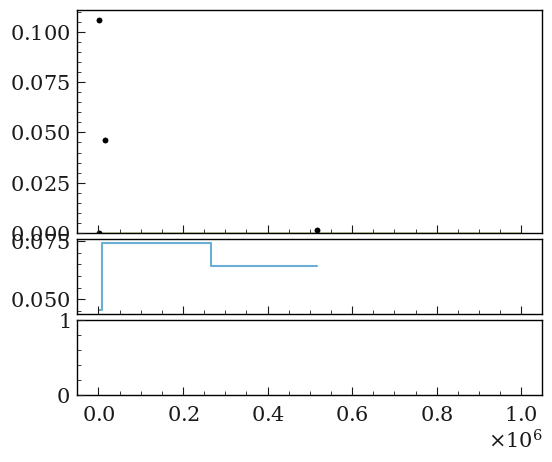

In [72]:
import textwrap
def wraplabel(text, width=30):
    return "\n".join(textwrap.wrap(text, width=width))

fig, axs = plt_subplots(nrows=3, height_ratios=[3,1,1])
fig.tight_layout(pad=3)

ax_main = axs[0]
hkw = dict(ax=ax_main, histtype='step', lw=1.5)
snames = [ 'astro', 'atm_conv']

var_name = 'monopod_energy_coarse'
var_info = variables[var_name]
var_info = deepcopy(var_info)

# 
# var_info['bins'] = np.geomspace(1, 1E6, 3)
# 

hists = get_hists(**var_info)

ph.plot_hist( [hists[sname] for sname in snames],
             color=[samples[sname].get('color', None) for sname in snames],
             label=[samples[sname].get('label', sname) for sname in snames],
             **hkw,
             )

snames_comp = ['corsika', 'mugun']

ph.plot_hist_uncertainties( hists['corsika'], ax=ax_main, 
                            color=samples['corsika']['color'],
                            hatch=None,
                            alpha=0.3,
                            fill=True,
                           )


cmap = plt.cm.get_cmap('Blues')

colors = {
    'pseudo_pred_gauss_0.2': 'green',
    'pseudo_pred_uniform_0.2': 'red',
}
_ = [h for h in  hists_pred if h not in colors]
for i, h in enumerate(_, 1):
    colors[h] = cmap(i/len(_))


icolor = 0
for hname, h in hists_pred.items():
    icolor += 1
    if not 'pseudo' in hname:
        label = "_".join(hname.split("_")[2:-3])
    else:
        label = hname
    ph.plot_hist_uncertainties( h, ax=ax_main, 
                                color=colors.get(hname ),
                                hatch=None,
                                alpha=0.3,
                                fill=True,
                                label=wraplabel(label, 20)
                            )



plot_error_hist(hists['data'], 
                ax_main, color='black')

ph.plot_error_hist(hists['data'], 
                ax_main, color='black')

ax_r = axs[1]
ax_c = axs[2]

foms = {}
for k,h in hists_pred.items():
    fom = calc_fom(hists['astro'], h)
    foms[k] = fom
    print(k, colors[k])
    label = wraplabel(label, 30)
    ax_r.step(x=h.axes[0].centers, y=fom, where='mid', label=label, color=colors[k])
    # cpu = 
    ax_c.hist()



yscale = var_info.get('yscale', 'log')
xscale = var_info.get('xscale', 'linear')
ax_main.set_yscale(yscale)
ax_main.set_xscale(xscale)

legend_kwargs = dict(ncol=3, fontsize=15, loc='upper center', bbox_to_anchor=(0.5, 1.15))
leg = ax_main.legend(**legend_kwargs)

for artist in leg.legendHandles:
    artist.set_alpha(1)
    #artist.set_linewidth(2)


ax_main.set_ylabel("event rate [Hz]")
ax_main.set_ylim(1E-8, 1E-1)

ax_r.set_xlabel(var)
ax_r.set_ylabel("astro/$\sqrt{atm}$")

#ax_r.legend(fontsize=9, ncols=2)




In [32]:
n_photons = df['n_photons']
weights = df['sel_gen_weights']

np.sum( n_photons*weights )

35324386669.71641

{'figsize': (6, 5), 'sharex': True, 'height_ratios': [3, 1], 'gridspec_kw': {'hspace': 0.05}, 'nrows': 2, 'ncols': 1}
base_large_v0.0_simple_v0.0_0.2 (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0)
base_1028_v0.0_muemb_v0.0_0.2 (0.03137254901960784, 0.18823529411764706, 0.4196078431372549, 1.0)
pseudo_pred_gauss_0.2 green
pseudo_pred_uniform_0.2 red


/tmp/ipykernel_2566870/3593501620.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=3)
/tmp/ipykernel_2566870/3593501620.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')


Text(0, 0.5, 'astro/$\\sqrt{atm}$')

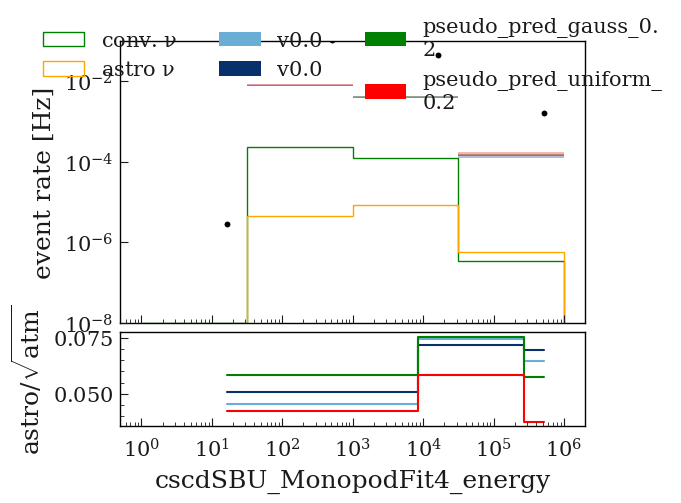

In [73]:
import textwrap
def wraplabel(text, width=30):
    return "\n".join(textwrap.wrap(text, width=width))

fig, axs = plt_subplots()
fig.tight_layout(pad=3)

ax_main = axs[0]
hkw = dict(ax=ax_main, histtype='step', lw=1.5)
snames = [ 'astro', 'atm_conv']


ph.plot_hist( [hists[sname] for sname in snames],
             color=[samples[sname].get('color', None) for sname in snames],
             label=[samples[sname].get('label', sname) for sname in snames],
             **hkw,
             )

snames_comp = ['corsika', 'mugun']

ph.plot_hist_uncertainties( hists['corsika'], ax=ax_main, 
                            color=samples['corsika']['color'],
                            hatch=None,
                            alpha=0.3,
                            fill=True,
                           )


cmap = plt.cm.get_cmap('Blues')

colors = {
    'pseudo_pred_gauss_0.2': 'green',
    'pseudo_pred_uniform_0.2': 'red',
}
_ = [h for h in  hists_pred if h not in colors]
for i, h in enumerate(_, 1):
    colors[h] = cmap(i/len(_))


icolor = 0
for hname, h in hists_pred.items():
    icolor += 1
    if not 'pseudo' in hname:
        label = "_".join(hname.split("_")[2:-3])
    else:
        label = hname
    ph.plot_hist_uncertainties( h, ax=ax_main, 
                                color=colors.get(hname ),
                                hatch=None,
                                alpha=0.3,
                                fill=True,
                                label=wraplabel(label, 20)
                            )



plot_error_hist(hists['data'], 
                ax_main, color='black')

ph.plot_error_hist(hists['data'], 
                ax_main, color='black')

ax_r = axs[1]

foms = {}
for k,h in hists_pred.items():
    fom = calc_fom(hists['astro'], h)
    foms[k] = fom
    print(k, colors[k])
    label = wraplabel(label, 30)
    ax_r.step(x=h.axes[0].centers, y=fom, where='mid', label=label, color=colors[k])

yscale = var_info.get('yscale', 'log')
xscale = var_info.get('xscale', 'linear')
ax_main.set_yscale(yscale)
ax_main.set_xscale(xscale)

legend_kwargs = dict(ncol=3, fontsize=15, loc='upper center', bbox_to_anchor=(0.5, 1.15))
leg = ax_main.legend(**legend_kwargs)

for artist in leg.legend_handles:
    artist.set_alpha(1)
    #artist.set_linewidth(2)


ax_main.set_ylabel("event rate [Hz]")
ax_main.set_ylim(1E-8, 1E-1)

ax_r.set_xlabel(var)
ax_r.set_ylabel("astro/$\sqrt{atm}$")

#ax_r.legend(fontsize=9, ncols=2)




{'figsize': (6, 5), 'sharex': True, 'height_ratios': [3, 1], 'gridspec_kw': {'hspace': 0.05}, 'nrows': 2, 'ncols': 1}
model_badf43a9_hyperband1_500epochs_CscdPreBDT_allfeat_w2_v3_0.2 (0.03137254901960784, 0.18823529411764706, 0.4196078431372549, 1.0)
pseudo_pred_gauss_0.2 green
pseudo_pred_uniform_0.2 red


/tmp/ipykernel_42083/1950674062.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=3)
/tmp/ipykernel_42083/1950674062.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')
/tmp/ipykernel_42083/1950674062.py:81: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for artist in leg.legendHandles:


Text(0, 0.5, 'astro/$\\sqrt{atm}$')

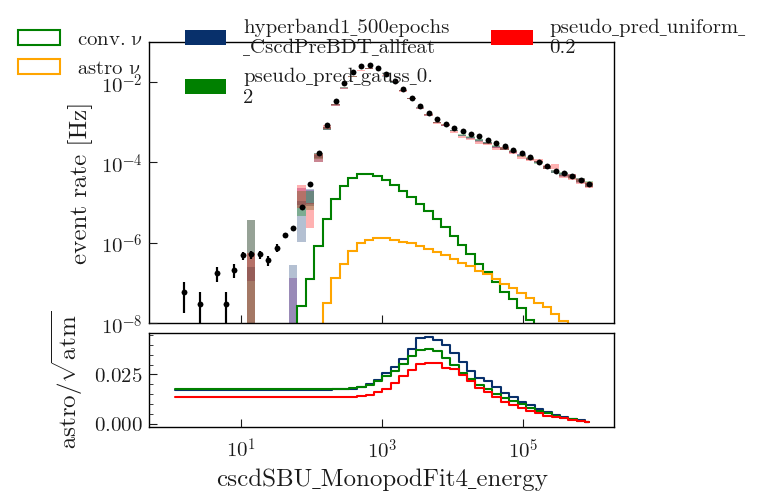

In [33]:
import textwrap
def wraplabel(text, width=30):
    return "\n".join(textwrap.wrap(text, width=width))

fig, axs = plt_subplots()
fig.tight_layout(pad=3)

ax_main = axs[0]
hkw = dict(ax=ax_main, histtype='step', lw=1.5)
snames = [ 'astro', 'atm_conv']


ph.plot_hist( [hists[sname] for sname in snames],
             color=[samples[sname].get('color', None) for sname in snames],
             label=[samples[sname].get('label', sname) for sname in snames],
             **hkw,
             )

snames_comp = ['corsika', 'mugun']

ph.plot_hist_uncertainties( hists['corsika'], ax=ax_main, 
                            color=samples['corsika']['color'],
                            hatch=None,
                            alpha=0.3,
                            fill=True,
                           )


cmap = plt.cm.get_cmap('Blues')

colors = {
    'pseudo_pred_gauss_0.2': 'green',
    'pseudo_pred_uniform_0.2': 'red',
}
_ = [h for h in  hists_pred if h not in colors]
for i, h in enumerate(_, 1):
    colors[h] = cmap(i/len(_))


icolor = 0
for hname, h in hists_pred.items():
    icolor += 1
    if not 'pseudo' in hname:
        label = "_".join(hname.split("_")[2:-3])
    else:
        label = hname
    ph.plot_hist_uncertainties( h, ax=ax_main, 
                                color=colors.get(hname ),
                                hatch=None,
                                alpha=0.3,
                                fill=True,
                                label=wraplabel(label, 20)
                            )



plot_error_hist(hists['data'], 
                ax_main, color='black')

ph.plot_error_hist(hists['data'], 
                ax_main, color='black')

ax_r = axs[1]

foms = {}
for k,h in hists_pred.items():
    fom = calc_fom(hists['astro'], h)
    foms[k] = fom
    print(k, colors[k])
    label = wraplabel(label, 30)
    ax_r.step(x=h.axes[0].centers, y=fom, where='mid', label=label, color=colors[k])

yscale = var_info.get('yscale', 'log')
xscale = var_info.get('xscale', 'linear')
ax_main.set_yscale(yscale)
ax_main.set_xscale(xscale)

legend_kwargs = dict(ncol=3, fontsize=15, loc='upper center', bbox_to_anchor=(0.5, 1.15))
leg = ax_main.legend(**legend_kwargs)

for artist in leg.legendHandles:
    artist.set_alpha(1)
    #artist.set_linewidth(2)


ax_main.set_ylabel("event rate [Hz]")
ax_main.set_ylim(1E-8, 1E-1)

ax_r.set_xlabel(var)
ax_r.set_ylabel("astro/$\sqrt{atm}$")

#ax_r.legend(fontsize=9, ncols=2)




## check coverage

In [ ]:
for sname, sinfo in samples.items():
    k = "cscdSBU_LE_bdt_input_CascadeLlhVertexFitParams_rlogL"
    k = 'cscdSBU_Qtot_HLC'
    k = "cscdSBU_LE_bdt_input_cscdSBU_VertexRecoDist_CscdLLh"
    df= sinfo['df']
    print(sname, k in df)
    print(sname, f"{np.min(df[k]):0.2e},   {np.max(df[k]):0.2e}" )
 
# k = 'cscdSBU_LE_bdt_input_CscdL3_SPEFit16FitParams_rlogl'
#get_hist_and_plot(k, np.linspace(0,50), xscale='linear')
#get_hist_and_plot(**variables['VertexRecoDist_CscdLLh'])


data True
data 5.49e-03,   1.38e+04
mugun True
mugun 4.53e-03,   4.35e+06
corsika True
corsika 0.00e+00,   2.32e+05
atm_conv True
atm_conv 2.72e-04,   1.05e+05
astro True
astro 2.72e-04,   1.05e+05


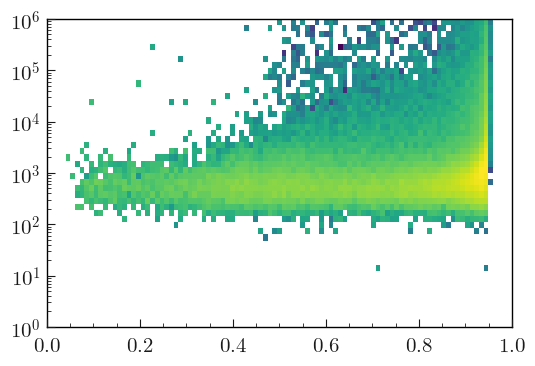

In [ ]:
_ = plt.hist2d(df_corsika[model_name], df_corsika[var],  weights=df_corsika['sel_gen_weights'],
               norm='log',
               bins=( np.linspace(0,1,100), bins)
               )
plt.yscale('log')

In [151]:
np.linspace(0,0.3, 31)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ])

0 0.0
cut=0.00e+00 | n_above = 7.275e-02 | n_below = 3.331e-02
4 0.04
8 0.08
cut=1.00e-01 | n_above = 1.271e-04 | n_below = 9.098e-05
12 0.12
16 0.16
20 0.2
cut=2.00e-01 | n_above = 4.751e-05 | n_below = 2.905e-05
24 0.24
28 0.28
cut=3.00e-01 | n_above = 2.184e-05 | n_below = 1.315e-05
{'dpi': 100, 'bbox_inches': 'tight'}
plot saved in: /data/user/navidkrad/plots/cascades_v0.6_CscdSBU_PreBDT/CscdPreBDT_allfeat_w2_v3/plots/NNScore_sliced_in_cascade_score.png
directory /data/user/navidkrad/plots/cascades_v0.6_CscdSBU_PreBDT/CscdPreBDT_allfeat_w2_v3/plots/NNScore_sliced_in_cascade_score.png --> 
https://convey.icecube.wisc.edu/data/user/navidkrad/plots/cascades_v0.6_CscdSBU_PreBDT/CscdPreBDT_allfeat_w2_v3/plots/NNScore_sliced_in_cascade_score.png


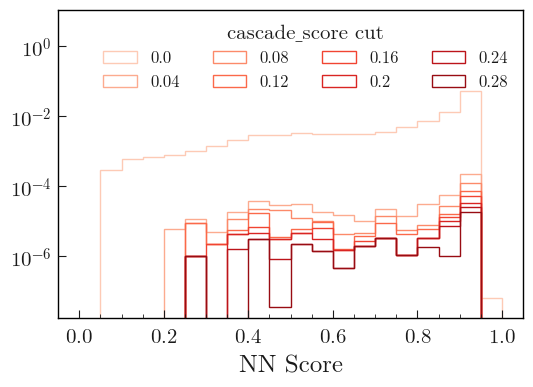

In [189]:


var_name = 'monopod_energy'

var_info = variables[var_name]
var = var_info['var']
bins = var_info['bins']


var = 'cscdSBU_LE_bdt_cascade'

var = 'cscdSBU_LE_bdt_hybrid'

var_name = 'cascade_score'

var_info = variables[var_name]
var = var_info['var']


model_name = model_names[0]



fig, ax = plt.subplots()
 
xbins = np.linspace(0,1,21)
kw = dict(bins=xbins, histtype='step')

cut_bins = np.linspace(0,0.3, 31)
cmap = plt.colormaps.get_cmap("Reds")
ratios = []
wrs = []

df = df_corsika.query(f'CscdBDT==1')

res_df = {}


colors = [cmap( (i+1)/10) for i in range(10) ]

ih = 1
for icut, cut in enumerate([0]+cut_bins,0):
    df_ = df.query(f'{var}>={cut}')

    
    #     ax.hist(df_[model_name], weights=df_['sel_gen_weights'], color=cmap(icut/len(cut_bins)), **kw)
    
    if icut%4==0:
        print(icut, cut)
        ax.hist(df_[model_name], 
                weights=df_['sel_gen_weights'], 
                ## color=cmap(icut/len(cut_bins)),
                color=colors[ih],
                label="%0.04s"%cut, 
                **kw,
                )
        ih+=1

    thresh = 0.8

    mask_above = df_[model_name]>thresh
    mask_below = df_[model_name]<=thresh
    w_above = (df_[mask_above]['sel_gen_weights']*1.0/df_[mask_above][model_name]).sum()
    w_below = (df_[mask_below]['sel_gen_weights']*1.0/df_[mask_below][model_name]).sum()

    n_above = df_[mask_above]['sel_gen_weights'].sum()
    n_below = df_[mask_below]['sel_gen_weights'].sum()

    #n_below = df_[df_[model_name]<=thresh] ['sel_gen_weights'].sum()

    ratios.append( n_above/(n_above+n_below) )
    wrs.append( w_above/(w_above+w_below) )
    if icut%10==0:
        print(f"{cut=:<5.2e} | {n_above = :0.3e} | {n_below = :0.3e}")
    res_df[cut] = dict(n_above=n_above, n_below=n_below, w_above=w_above, w_below=w_below)


ax.set_yscale('log')
ax.set_xlabel("NN Score")
ax.set_ylim(ymax=ax.get_ylim()[1]*1E2)
ax.legend(title='%s cut'%var_name, ncols=4)

savefig(fig, os.path.join(plot_dir, "NNScore_sliced_in_%s.png"%var_name))



{'dpi': 100, 'bbox_inches': 'tight'}


plot saved in: /data/user/navidkrad/plots/cascades_v0.6_CscdSBU_PreBDT/CscdPreBDT_allfeat_w2_v3/plots/NNScore_above_below_cascade_score_0p8.png
directory /data/user/navidkrad/plots/cascades_v0.6_CscdSBU_PreBDT/CscdPreBDT_allfeat_w2_v3/plots/NNScore_above_below_cascade_score_0p8.png --> 
https://convey.icecube.wisc.edu/data/user/navidkrad/plots/cascades_v0.6_CscdSBU_PreBDT/CscdPreBDT_allfeat_w2_v3/plots/NNScore_above_below_cascade_score_0p8.png


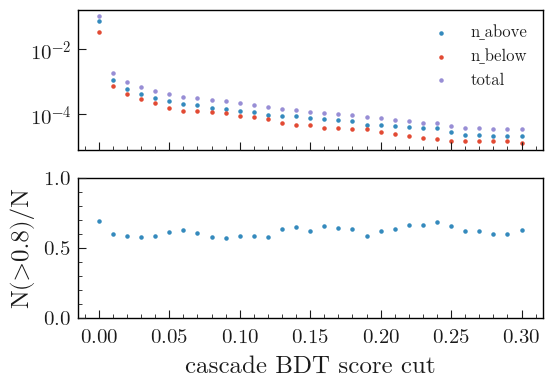

In [190]:
cutdf = pd.DataFrame(res_df).T
cutdf

skw = dict(s=5)
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
ax1.scatter(cutdf.index, cutdf['n_above'], label='n_above', **skw)
ax1.scatter(cutdf.index, cutdf['n_below'], label='n_below', **skw)
ax1.scatter(cutdf.index, (cutdf['n_below']+cutdf['n_above']), label='total' , **skw)
ax1.set_yscale('log')
ax1.legend()

ax2.scatter(cutdf.index, cutdf['n_above']/(cutdf['n_below']+cutdf['n_above']), **skw )

ax2.set_ylabel(f"N(>{thresh})/N")
ax2.set_xlabel(f"{var_info.get('label', var)} cut")
ax2.set_ylim(0,1)
savefig(fig, os.path.join(plot_dir, "NNScore_above_below_%s_%s.png"%(var_name, str(thresh).replace(".","p" ))))



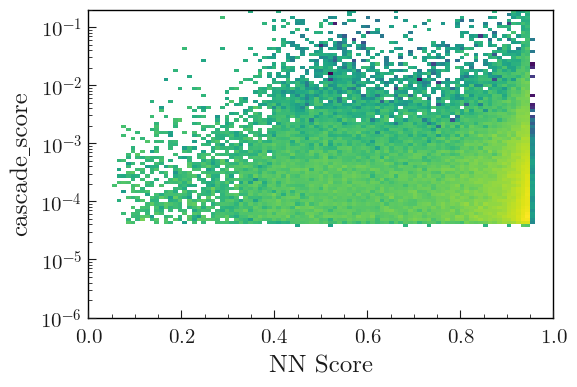

In [ ]:

var = var_info['var']

fig, ax = plt.subplots()
_ = ax.hist2d(df_corsika[model_name], df_corsika[var],  weights=df_corsika['sel_gen_weights'],
               norm='log',
               #bins=( np.linspace(0,1,100), bins)
               bins=(np.linspace(0,1,100), np.geomspace(1E-6,0.2,100) )
               )

ax.set_ylabel(var_name)
ax.set_xlabel("NN Score")
ax.set_yscale('log')

utils.savefig(fig, os.path.join(plot_dir, ))

In [32]:
model_name = model_names[0]

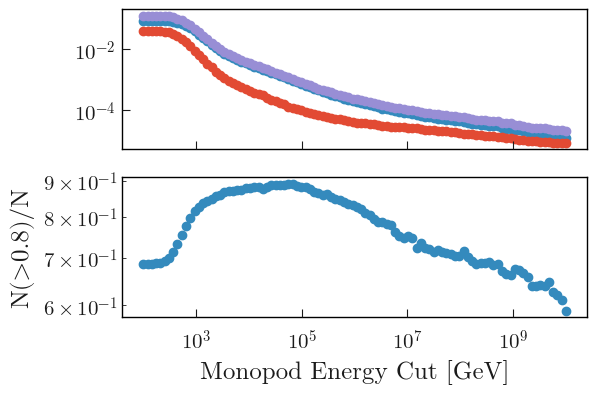

In [170]:
cutdf = pd.DataFrame(res_df).T
cutdf

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
ax1.scatter(cutdf.index, cutdf['n_above'])
ax1.scatter(cutdf.index, cutdf['n_below'])
ax1.scatter(cutdf.index, (cutdf['n_below']+cutdf['n_above']) )
ax1.set_yscale('log')

ax2.scatter(cutdf.index, cutdf['n_above']/(cutdf['n_below']+cutdf['n_above']) )
#plt.yscale('log')

ax2.set_ylabel(f"N(>{thresh})/N")
ax2.set_xlabel("Monopod Energy Cut [GeV]")
#ax2.set_xscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')


Text(0.5, 0, 'NN Score')

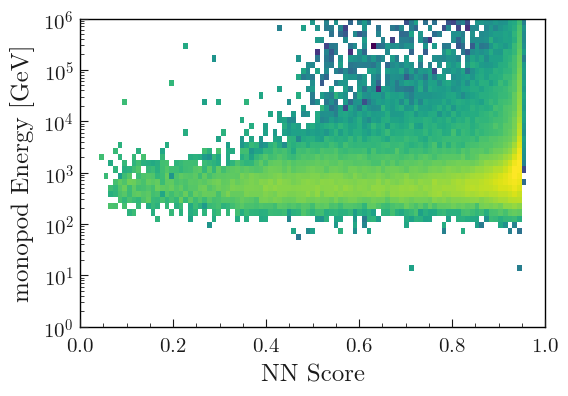

In [37]:
#model_badf43a9_hyperband1_500epochs
var=variables['monopod_energy']['var']

_ = plt.hist2d(df_corsika[model_name], df_corsika[var],  weights=df_corsika['sel_gen_weights'],
               norm='log',
               bins=( np.linspace(0,1,100), variables['monopod_energy']['bins'])
               )
plt.yscale('log')
plt.ylabel('monopod Energy [GeV]')
plt.xlabel("NN Score")

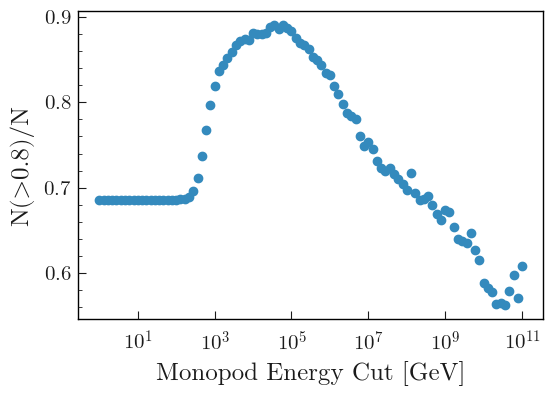

In [ ]:
#fig, ax = plt.subplots()

#
# plt.scatter( *list(zip(*ratios)) )

fig, ax = plt.subplots()
ax.scatter(cut_bins, ratios)
#plt.yscale('log')
ax.set_ylabel(f"N(>{thresh})/N")
ax.set_xlabel("Monopod Energy Cut [GeV]")
ax.set_xscale('log')


#plt.scatter()

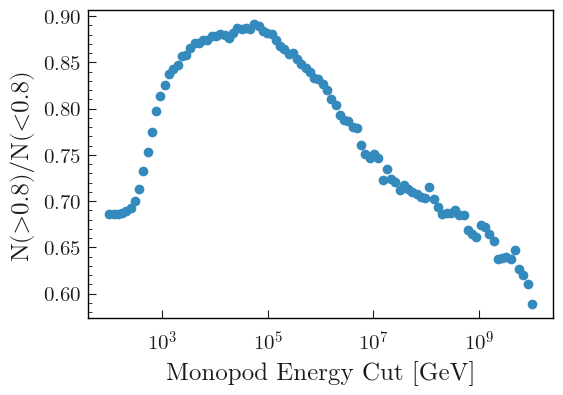

In [78]:
#fig, ax = plt.subplots()

#
# plt.scatter( *list(zip(*ratios)) )

fig, ax = plt.subplots()
ax.scatter(cut_bins, ratios)
#plt.yscale('log')
ax.set_ylabel(f"N(>{thresh})/N(<{thresh})")
ax.set_xlabel("Monopod Energy Cut [GeV]")
ax.set_xscale('log')


#plt.scatter()

In [2]:
[k for k in list(df_corsika) if 'bdt' in k]

df_corsika[cls1]['cscdSBU_LE_bdt_track']




659749     0.999582
794023     0.999227
2445690    0.999837
2834885    0.999685
2742171    0.999907
             ...   
173675          NaN
61382           NaN
307151     0.971779
46747           NaN
366147          NaN
Name: cscdSBU_LE_bdt_track, Length: 109054, dtype: float64

In [8]:
plot_params_dict = {
    "CascadeLlhVertexFit_L2Params_rlogl": {
        "bins": np.linspace(6, 10, 41),
        "reco_name": "CascadeLlhVertexFit_L2Params",
        "var": "rlogL",
    },
    "cscdSBU_VetoMaxDomChargeOM_value": {
        "bins": np.linspace(0, 60, 61),
        "reco_name": "cscdSBU_VetoMaxDomChargeOM",
        "var": "value",
    },
    "cscdSBU_MonopodFit4_noDC_z": {
        "bins": np.linspace(-500, 500, 51),
        "reco_name": "cscdSBU_MonopodFit4_noDC",
        "var": "z",
    },
    "cscdSBU_Qtot_HLC_value": {
        "bins": np.logspace(1, 6, 26),
        "reco_name": "cscdSBU_Qtot_HLC",
        "var": "value",
    },
    "cscdSBU_Qtot_HLC_IC_value": {
        "bins": np.logspace(1, 6, 26),
        "reco_name": "cscdSBU_Qtot_HLC_IC",
        "var": "value",
    },
    "cscdSBU_I3XYScale_noDC_value": {
        "bins": np.linspace(0, 1.5, 31),
        "reco_name": "cscdSBU_I3XYScale_noDC",
        "var": "value",
    },
    "cscdSBU_MonopodFit4_noDC_Delay_ice_value": {
        "bins": np.linspace(-20000, 0, 41),
        "reco_name": "cscdSBU_MonopodFit4_noDC_Delay_ice",
        "var": "value",
    },
    "cscdSBU_MonopodFit4_energy": {
        "bins": np.logspace(1, 5, 41),
        "reco_name": "cscdSBU_MonopodFit4",
        "var": "energy",
    },
}


index_columns={}
columns = []
for k, info in plot_params_dict.items():
    reco_name = info['reco_name']
    columns.append(reco_name)
    var = info['var']
    if not var == 'value':
        if not reco_name in index_columns:
            index_columns[reco_name] = []
        index_columns[reco_name].append(var)

from pprint import pprint
pprint(columns)
pprint(index_columns)


['CascadeLlhVertexFit_L2Params',
 'cscdSBU_VetoMaxDomChargeOM',
 'cscdSBU_MonopodFit4_noDC',
 'cscdSBU_Qtot_HLC',
 'cscdSBU_Qtot_HLC_IC',
 'cscdSBU_I3XYScale_noDC',
 'cscdSBU_MonopodFit4_noDC_Delay_ice',
 'cscdSBU_MonopodFit4']
{'CascadeLlhVertexFit_L2Params': ['rlogL'],
 'cscdSBU_MonopodFit4': ['energy'],
 'cscdSBU_MonopodFit4_noDC': ['z']}


# Junk

In [154]:
hists_pred = {}
# for sname, info in samples.items():
sname = 'corsika'    

for p, pred_name, min_pred in ( (pred, 'pred_0.6', 0.6), (pred, 'pred_0.2', 0.2), ):

    p = np.where(p>min_pred, p, min_pred)
    pred_weights, pred_mask = speedup_utils.get_weight_from_pred(p)

    # df = df_corsika[pred_mask]
    # df = apply_sel(df)
    weights = df_corsika[pred_mask]['weights'] * pred_weights[pred_mask]

    h = make_hist(df_corsika[pred_mask][var], weights=weights, bins=bins)
    hists_pred[pred_name] = h

    


/tmp/ipykernel_14200/1388877116.py:14: RangeWarning: Only 1.63% of data contained in the binning range [1.0, 1000000.0].
  h = make_hist(df_corsika[pred_mask][var], weights=weights, bins=bins)
/tmp/ipykernel_14200/1388877116.py:14: RangeWarning: Only 1.64% of data contained in the binning range [1.0, 1000000.0].
  h = make_hist(df_corsika[pred_mask][var], weights=weights, bins=bins)


{'figsize': (6, 5), 'sharex': True, 'height_ratios': [3, 1], 'gridspec_kw': {'hspace': 0.05}, 'nrows': 2, 'ncols': 1}


Text(0, 0.5, '$S/\\sqrt{B}$')

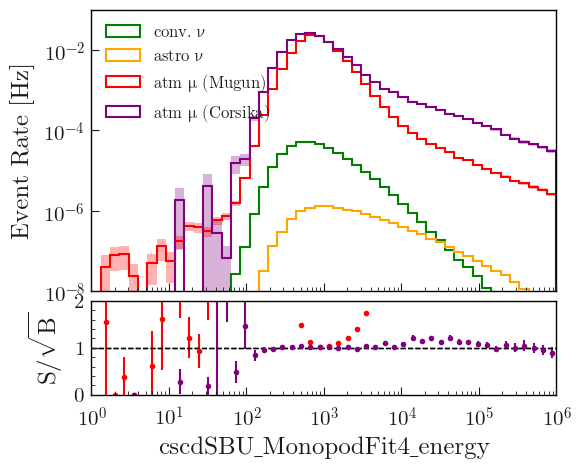

In [43]:
dict(
             color=[samples[sname].get('color', None) for sname in snames],
             label=[samples[sname].get('label', sname) for sname in snames],
             **hkw,
             )

             

{'color': [None, 'red', 'orange', 'green'],
 'label': ['atm $\\mu$ (Corsika)',
  'atm $\\mu$ (Mugun)',
  'astro $\nu$',
  'conv. $\nu$'],
 'ax': <Axes: >,
 'histtype': 'step',
 'lw': 1.5}

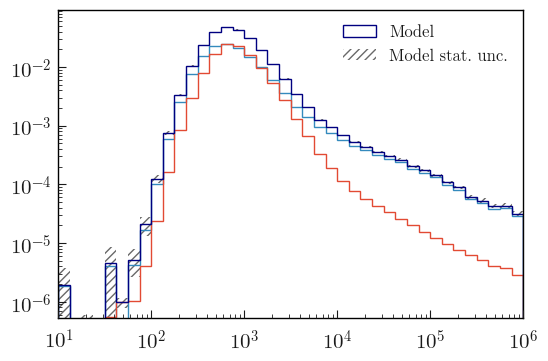

In [43]:
fig, ax = plothist.plot_model(
    #stacked_components=background_hists,
    #stacked_labels=background_categories_labels,
    #stacked_colors=background_categories_colors,
    unstacked_components=[hists['corsika'], hists['mugun']],
    #unstacked_labels=["Signal"],
    #unstacked_colors=["black"],
    #unstacked_kwargs_list=[{"linestyle": "dotted"}],
    #xlabel=key,
    #ylabel="Entries",
    #model_sum_kwargs={"show": True, "label": "Model", "color": "navy"},
    #model_uncertainty_label="Stat. unc.",
)
ax.set_yscale('log')
ax.set_xscale('log')


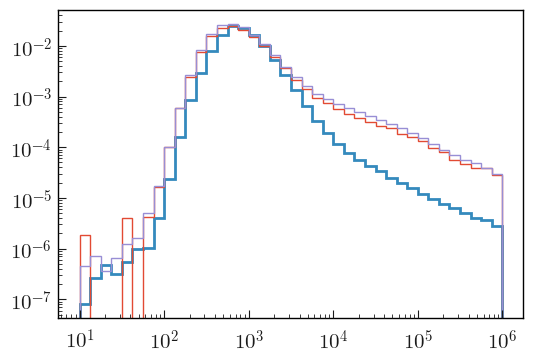

In [25]:
var  = 'cscdSBU_MonopodFit4_energy'
bins = np.logspace(1, 6, 41)

fig, ax = plt.subplots()
hkw = dict(bins=bins, histtype='step',)
ax.hist(df_mugun[var], weights=df_mugun['weights'], lw=2, **hkw)
ax.hist(df_test[var], weights=df_test['weights'],  **hkw)

# ax.hist(df_data[var], weights=df_data['weights'], **hkw)
# for v in df_nugen.values():
#     ax.hist(v[var], weights=v['weights'], **hkw)
 
ax.set_yscale('log')
ax.set_xscale('log')



In [5]:
cut_params1 = ("energy",np.array([0,60000]))
plot_params = {
    "bins":np.logspace(1,5,41),
    "reco_name":"cscdSBU_MonopodFit4",
    "var":"energy",
    }
ax1_params = {"xscale":"log", 'ylim':[1E-8, 1E-1]}
ax2_params = ax1_params.copy()
outfile = f"l3sc/cscdSBU_MonopodFit4_energy.png"
xunit="[GeV]"
final_plot(cut_params1=cut_params1, cut_params2=cut_params2, plot_params=plot_params, ax1_params=ax1_params,ax2_params=ax2_params,title=title,xunit=xunit,outfile=None)



NameError: name 'final_plot' is not defined

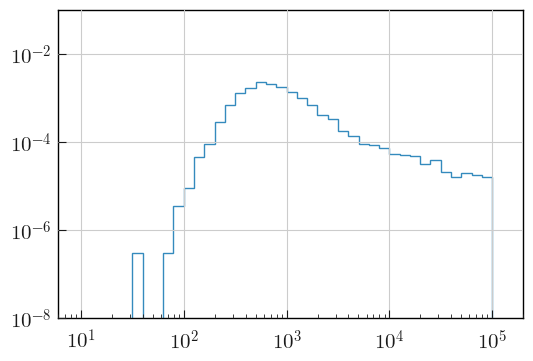

In [2]:
df[["Level3", "CscdPreBDT"]].value_counts()
label = "CscdPreBDT"
cls0 = df[label] == 0
cls1 = df[label] == 1

fig, ax = plt.subplots()

hkw = dict(bins=np.geomspace(1E2,1E7,51), histtype="step")
hkw = dict(bins=np.logspace(1,5,41), histtype="step")

_ = ax.hist(df[cls1]["cscdSBU_MonopodFit4_energy"],  weights=df[cls1]['weights'], **hkw )

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylim(1E-11, 1E-1)
ax.set_xlim(6E0, 2E5)
ax.set_ylim(1E-8, 1E-1)
ax.grid(True)




In [43]:
from ModelFactory import ModelFactory
import tensorflow as tf

import os
import pickle
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# from utils import
import utils
from utils import tf_utils

from features import select_features, DEFAULT_FEATURES

import inspect
from defaults import *
from utils.speedup_utils import *


model_infos = [ 
                #("cascades_v0.3_L3", "gen2L3_allfeatures_gen_weights_balanced_bayesian2_20epochs"),
                ("cascades_v0.3_L3", "gen2L3_ngammauncorr_gen_weights_balanced_bayesian2_50epochs"),
                ("cascades_v0.4_L3", "gen2L3_wflux2_bal_allfeat_v0_hyperband4_500epochs"),
                #("cascades_v0.4_L3", "gen2L3_nguncorr_logactspeedup_hyperband3_50epochs"),
                ("cascades_v0.4_L3", "gen2L3_wflux2_bal_Egt1E6_v0_hyperband4_500epochs"),
                ("cascades_v0.4_L3", "gen2L3_wflux2_bal_v0_hyperband1_50epochs"),
                #("cascades_v0.4_L3", "gen2L3_allfeat_bayesian1_50epochs"),
                #("cascades_v0.4_L3", "gen2L3_allfeat_fluxwbalanced"),
                #"gen2L3_merged_combinedall_allfeatures",
                #"gen2L3_merged_combinedall_allfeatures_hyperband1",
                #"gen2L3_merged_combinedall_allfeatures_hyperband4",
              ]



model_names = [] 

mfs = {}

i = 0
for model_name in model_infos:
    if isinstance(model_name, (tuple, list)):
        version_tag, model_name = model_name
    else:
        version_tag = DEFAULT_VERSION_TAG
    if i==0:
        nominal_model = model_name

    mf = ModelFactory.load_model(version_tag=version_tag, model_name=model_name)

    mfs[model_name] = mf
    model_names.append( model_name )
    i += 1

mf = mfs[nominal_model]

loading model from:  /data/user/navidkrad/i3kiss/models/cascades_v0.3_L3/gen2L3_ngammauncorr_gen_weights_balanced_bayesian2_50epochs/model.keras
MODEL <keras.src.engine.sequential.Sequential object at 0x7f9f5aa22a50>
loading weights from:  /data/user/navidkrad/i3kiss/models/cascades_v0.3_L3/gen2L3_ngammauncorr_gen_weights_balanced_bayesian2_50epochs/weights.h5
loading model from:  /data/user/navidkrad/i3kiss/models/cascades_v0.4_L3/gen2L3_wflux2_bal_allfeat_v0_hyperband4_500epochs/model.keras
MODEL <keras.src.engine.sequential.Sequential object at 0x7f9f59142710>
loading weights from:  /data/user/navidkrad/i3kiss/models/cascades_v0.4_L3/gen2L3_wflux2_bal_allfeat_v0_hyperband4_500epochs/weights.h5
loading model from:  /data/user/navidkrad/i3kiss/models/cascades_v0.4_L3/gen2L3_wflux2_bal_Egt1E6_v0_hyperband4_500epochs/model.keras
MODEL <keras.src.engine.sequential.Sequential object at 0x7f9f5904c890>
loading weights from:  /data/user/navidkrad/i3kiss/models/cascades_v0.4_L3/gen2L3_wflux2

In [3]:
import simweights
simweights.__version__

def get_weights(
    fgen, nfiles=None, flux="GaisserH4a", return_weighter=False, verbose=True
):  
    import simweights

    print(f"{simweights.__path__=}")
    print(f"{simweights.__version__=}")
    hdffile = pd.HDFStore(fgen, "r")

    # instantiate the weighter object by passing the pandas file to it
    weighter = simweights.CorsikaWeighter(hdffile, nfiles=nfiles)
    flux = getattr(simweights, flux)() if isinstance(flux, str) else flux
    weights = weighter.get_weights(flux)
    if verbose:
        print(weighter.tostring(flux))
    if return_weighter:
        return weights, weighter
    else:
        return weights




In [4]:
for model_name, mf in mfs.items():
    print(model_name, mf.model.layers[-1])

gen2L3_ngammauncorr_gen_weights_balanced_bayesian2_50epochs <keras.src.layers.core.dense.Dense object at 0x7fa06c7ad810>
gen2L3_wflux2_bal_allfeat_v0_hyperband4_500epochs <keras.src.layers.core.dense.Dense object at 0x7fa06c51dbd0>
gen2L3_wflux2_bal_Egt1E6_v0_hyperband4_500epochs <keras.src.layers.core.dense.Dense object at 0x7fa06c44c490>
gen2L3_wflux2_bal_v0_hyperband1_50epochs <keras.src.layers.core.dense.Dense object at 0x7fa06c4b0150>


In [5]:
#plot_dir = "/data/user/navidkrad/plots/pres/feb2024"
plot_dir = "/data/user/navidkrad/plots/pres/july2024"

label = mf.labels[0]

label_names = {
    'Level3':'L3',
    'filtered':'L2',
}

label_name = label_names.get(label, label)

labels = {
    'n_photons_passed'    : r'$N_{%s}^{\gamma}$'%(label_name),
    'n_photons_accepted' : r'$N_{NN}^{\gamma}$',
    'n_photons_accepted' : r'$N_{NN}^{\gamma}$',
    'n_events_eff'     : r'$N^{NN}_{eff} (pred*gen weights)$',
    'n_events_eff_pred'     : r'$N^{%s}_{eff}$'%(label_name),   
    'n_events_eff_pred_sel'     : r'$N^{%s}_{eff}$'%(label_name),     
    'n_events_eff_gen'     : r'$N^{%s}_{eff} (gen weight)$'%(label_name),    
    'n_events_accepted'  : r'$N^{NN}_{events}$',
    'n_photons_simulated_sel' : r'$N^{simulated}_{\gamma}$ (sel)',
    

    "n_photons_simulated": "$<N_{\gamma}^{sim}>$",
    "n_photons_simulated_0": "$<N_{simulated\ showers}>$",
    "n_photons_simulated_2": "$<N_{\gamma}^{sim} (n_{\gamma}^2)>$",
    "n_eff_passed": "$<N_{eff}^{%s}>$"%(label_name),
    "n_eff_noflux_passed": "$<N_{eff}^{%s, raw}>$"%(label_name),

    'n_eff_sampled_expected' : r'$<N^{%s}_{eff,raw}>$'%(label_name),
    'n_eff_sampled_gen_expected' : r'$<N^{%s}_{eff}>$'%(label_name),
    'n_photons_sampled_expected' : r'$<N_{\gamma}>$',
    # 'n_photons_sampled_gen_expected' : r'$<N^{%s}_{\gamma}>$',

    #'min_pred':'Rejection Probability Threshold',
    'min_pred':'Minimum Acceptance Probability',

    #'fake_pred':'Utopian',
    'fake_pred':'Ideal',
    'pred':'model',
    #'uniform_pred':'Dystopian', 
    'uniform_pred':'Uniform', 
}

colors = {
    'fake_pred': 'green',
    'uniform_pred': 'red',
    'pred': 'blue'
}




for k, v in list(infos.items()):
    infos[k+"_prob"] = dict(color=v.get('color'), label=v['label'], ls='--' )


In [6]:
"""
    Load DF
"""

import glob
test_file = "/data/user/navidkrad/hdf/cascades_v0.2_L3//sim/IceCube/2020/CORSIKA-in-ice/20904/test_train_balanced/test_preproc.hdf5"
train_file = "/data/user/navidkrad/hdf/cascades_v0.2_L3//sim/IceCube/2020/CORSIKA-in-ice/20904/test_train_balanced/train_preproc.hdf5"

# fname = train_file
fname = test_file

df_biased = pd.read_hdf(fname)

label = mf.labels[0]
cls0 = df_biased[label]==0
cls1 = df_biased[label]==1




In [7]:
# d['selection_weight']

df = df_biased

cls0 = df[label]==0
cls1 = df[label]==1

## Adding Predictions

In addition to the model predictions, the following are also added:
- pseudo predictions: used only as a reference in the "ideal" or "worst" case scenarios
- class probabilities: instead of using the NN score as probability, we use the ratio of the number of events in the positive class to the total number of events in the bin
- logistic predictions: we calibrate the activation function of the NN to better seperate the positive and negative classes.


In [8]:
df['pred']   =  mf.model.predict(df[mf.features], batch_size=mf.batch_size)
df['truth']  =  df['Level3'] == 1
df['passed'] = df['truth']

41/41 [==============================] - 0s 5ms/step


In [9]:
print("weight columns:")
print( [k for k in df.columns if "weight" in k] )

weight columns:
['weights', 'selection_weight', 'balanced_weight', 'gen_weights_balanced', 'gen_weights', 'sel_gen_weights', 'normalized_balanced_weights']


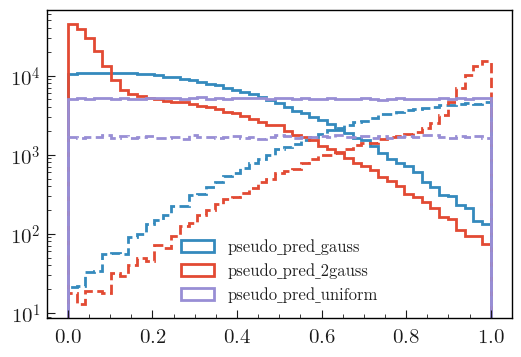

In [10]:
##
## Add pseudo predictions for comparison. 
##

add_pseudo_preds(df)

fig, ax =plt.subplots()

icolor = 0
for pseudo_pred in ['pseudo_pred_gauss', 'pseudo_pred_2gauss', 'pseudo_pred_uniform']:
    kw = dict(histtype='step', lw=2)
    kw['bins'] = np.linspace(0,1,50)
    _ = ax.hist(df[pseudo_pred][df['Level3']==0], **kw, color=f"C{icolor}", label=f'{pseudo_pred}')
    _ = ax.hist(df[pseudo_pred][df['Level3']==1], **kw, color=f"C{icolor}", ls="--") 
    icolor+=1

ax.set_yscale("log")
ax.legend()



In [11]:
preds = {}

for model_name in model_names:
    # print(model_name)
    # print(mf.features)
    mf_ = mfs[model_name]
    pred = mf_.model.predict(df[mf_.features], batch_size=mf_.batch_size)
    #preds[model_name] = pred
    df[model_name] = pred

    _ = get_class_probability(df, "Level3", 
                              pred=model_name, 
                              # weight_columns=['selection_weight', 'weights'],
                              weight_columns=['weights'],
                              # weight_columns=['gen_weights_balanced'],
                              bins=100, return_func="polyfit")

label = mf.labels[0]
df['truth'] = df[label]

41/41 [==============================] - 1s 11ms/step
coefs = array([ 1.7471552 , -3.64120679,  5.73614411, -6.05049207])
 9/41 [=====>........................] - ETA: 0s

41/41 [==============================] - 1s 14ms/step
coefs = array([ 17.27285653, -22.76601823,  13.23375401,  -7.9703689 ])
41/41 [==============================] - 1s 13ms/step
coefs = array([ -7.03306221,  21.97251504, -15.65858945,  -1.45439582])
41/41 [==============================] - 0s 6ms/step
coefs = array([ 34.34092647, -54.96371618,  32.24038337, -10.79509389])


In [12]:
[k for k in df.columns if 'pred' in k]
def calc_expected_livetime(w, p=None):
    if p is None:
        expected_lt = (len(w)) / (w).sum()
    else:
        expected_lt = (p*w).sum()/( p*(w)**2).sum()
    # print(w.sum(), len(w), expected_n_eff)
    return expected_lt

In [13]:
p = df['pseudo_pred_uniform']
# p = df['pred']
w_pred, mask = get_weight_from_pred(p)
w_flux = df['gen_weights']
w_sel = df['selection_weight']

print(calc_livetime(w_flux * w_sel))
print( calc_livetime( (w_flux * w_sel * w_pred)[mask] ) )
print( calc_expected_livetime( (w_flux * w_sel), p ))
#print( calc_)

5.545339685608195
1.127417209750687
5.541275936797972


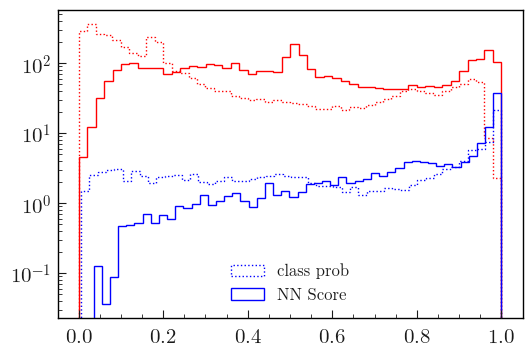

In [14]:
"""
compare the NN score vs the "class probabilities"
"""


pred_key = nominal_model
fig, ax = plt.subplots()

weight_columns = ['selection_weight', 'weights']
weight_columns = ['gen_weights_balanced']
weight_columns = ['weights']

w = combine_weight_columns(df, weight_columns=weight_columns)
                           
kw = dict(bins=50, histtype='step')
ax.hist( df[cls0][f'{pred_key}_prob'], weights=w[cls0], color='red', ls=':', **kw)
ax.hist( df[cls1][f'{pred_key}_prob'], weights=w[cls1], color='blue', ls=':', **kw, label='class prob')

ax.hist( df[cls0][f'{pred_key}'], weights=w[cls0], color='red',  **kw)
ax.hist( df[cls1][f'{pred_key}'], weights=w[cls1], color='blue', label='NN Score', **kw, )

ax.set_yscale('log')
ax.legend()

print()

### Calibrate the activation function
Here we calibrate the the activation function by playing around with the logistic function in order to improve the speedup.

In [15]:
bare_model = remove_final_activation(mf.model)
bare_res = bare_model.predict(df[mf.features], batch_size=mf.batch_size)


pars =     [ (1, 1, 1),
    (2, 1, 1),
    (1, 2, 1),
    (0.5,2,1),
    (1,3,1),
    (1,2,0.5),
    (1, 1, 2),
    (2, 1, 2),
    (0.5,1,2),
           ]


results = {}
logistic_names = []
for par in pars:
    name = "logistic_%s_%s_%s"%par
    df[name] = logistic(bare_res, *par)
    logistic_names.append(name)
    print(name)

    _ = get_class_probability(df, "Level3", 
                              pred=name, 
                              # weight_columns=['selection_weight', 'gen_weights'],
                              # weight_columns=['sel_gen_weights'],
                              weight_columns=['weights'], 
                              # weight_columns=['gen_weights_balanced'],
                              bins=100, return_func="polyfit")



41/41 [==============================] - 0s 5ms/step
logistic_1_1_1
coefs = array([ 10.10520949, -19.08367607,  17.07661409,  -7.76527882])
logistic_2_1_1
coefs = array([ 31.30700159, -59.3579467 ,  42.15264572, -13.25925149])
logistic_1_2_1
coefs = array([  7.67774265, -18.88610523,  17.66170315,  -6.40735912])
logistic_0.5_2_1
coefs = array([  7.86364025, -17.4311714 ,  14.77805192,  -5.12108038])
logistic_1_3_1
coefs = array([ 17.88091319, -35.48135356,  23.41820924,  -5.49021505])
logistic_1_2_0.5
coefs = array([ 34.34086403, -69.27243368,  49.2827938 , -12.9768203 ])
logistic_1_1_2
coefs = array([  9.0817693 , -14.25581442,  10.34410519,  -5.5991977 ])
logistic_2_1_2
coefs = array([ 17.13453069, -29.00006595,  19.32684693,  -7.66111108])
logistic_0.5_1_2
coefs = array([  7.43411827, -11.01808734,   7.96599297,  -4.8646417 ])


/home/navidkrad/work/i3kiss/utils/speedup_utils.py:533: RuntimeWarning: overflow encountered in square
  return 1 / ((1 + a * np.exp(-c*(x-b)))**(1/a))


/home/navidkrad/work/i3kiss/utils/speedup_utils.py:693: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=3)


truth {'alpha': 0.8, 'ls': None, 'lw': 2}

n_photons_passed = 3.56e+13
n_photons_total  = 3.00e+15
--------------
ratio = 84.29


n_eff_passed = 5.85e+04
n_eff_total  = 1.18e+04
--------------
ratio = 4.95e+00

speed_passed = 1.64e-09
speed_total  = 3.94e-12
--------------
ratio = 4.17e+02

84.28605204474425



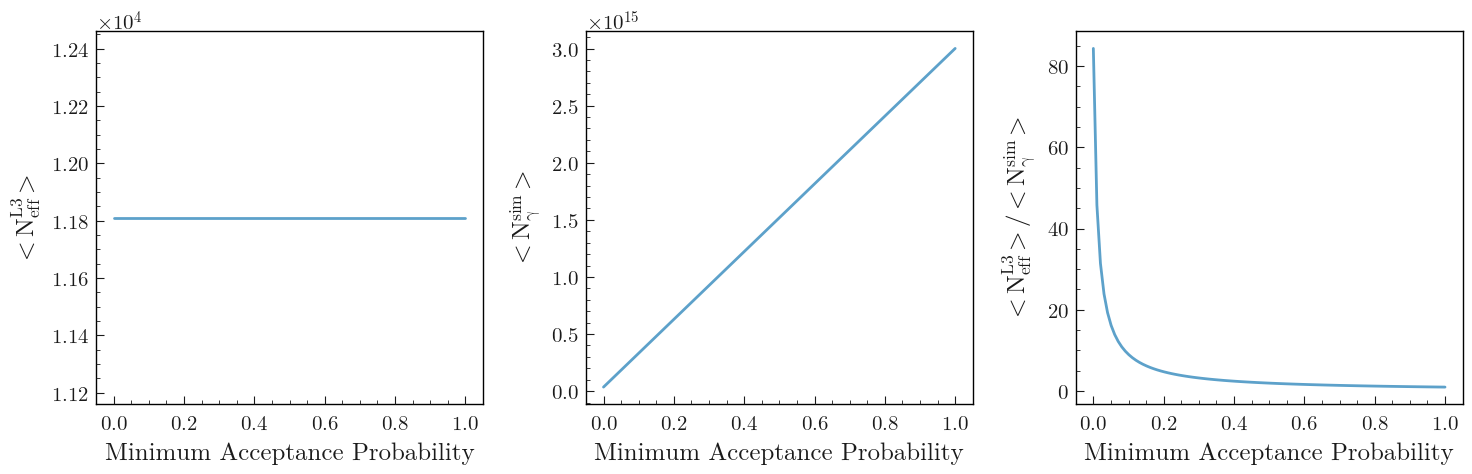

In [16]:
## Best Case Scenario (truth based prediction):

passed = df['passed']
pred_truth = df['passed']
w_sel = df['selection_weight']
w_flux = df['weights']
n_photons = df['n_photons']


sdf = get_pred_speed_up(df, pred_truth, min_pred_range=np.linspace(0,1,100))
fig, axs = make_tri_plot('n_eff_passed', 'n_photons_simulated', sdfs={'truth':sdf}, legend=False)

n_photons_passed = (w_sel * n_photons)[passed].sum()
n_photons_total  = (w_sel * n_photons).sum()


n_eff_passed = calc_n_eff( (w_flux * w_sel ) )
n_eff_total  = calc_n_eff( (w_flux * w_sel )[passed] )

print(
f"""
n_photons_passed = { n_photons_passed:0.2e}
n_photons_total  = { n_photons_total:0.2e}
--------------
ratio = {n_photons_total/n_photons_passed:0.2f}


n_eff_passed = { n_eff_passed:0.2e}
n_eff_total  = { n_eff_total:0.2e}
--------------
ratio = {n_eff_passed/n_eff_total:0.2e}

speed_passed = {n_eff_passed/n_photons_passed:0.2e}
speed_total  = {n_eff_total/n_photons_total:0.2e}
--------------
ratio = {n_eff_passed/n_photons_passed / (n_eff_total/n_photons_total):0.2e}

{n_photons_total/n_photons_passed}
"""
)



## Prediction Correlation to Computation Cost?

In [19]:
def label_sim_levels(df, sim_levels=['generated', 'triggered', 'filtered', 'Level3'], key='sim_level'):
    masks = {}
    for i, t in enumerate(sim_levels):
        query_this = f'{t}==1'
        query_rest = [f'{t_}==0' for t_ in sim_levels if sim_levels.index(t_) > sim_levels.index(t) ]
        query = " & ".join( [query_this] + query_rest)
        mask = df.query(query).index
        print( query )
        masks[t] = mask
        df.loc[mask, key] = t
    return df, masks



sim_levels = ['generated', 'triggered', 'filtered', 'Level3']
_ = label_sim_levels(df)

generated==1 & triggered==0 & filtered==0 & Level3==0
triggered==1 & filtered==0 & Level3==0
filtered==1 & Level3==0
Level3==1


In [54]:
matplotlib.colors.NoNorm

matplotlib.colors.NoNorm

10000.0 9.70e+05
1000.0 1.91e+05
200.0 5.14e+04
1.0 5.72e+03


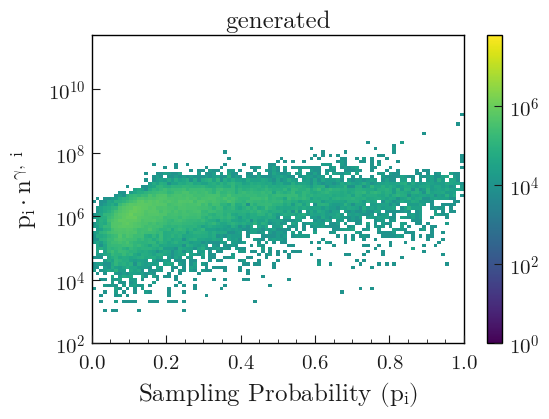

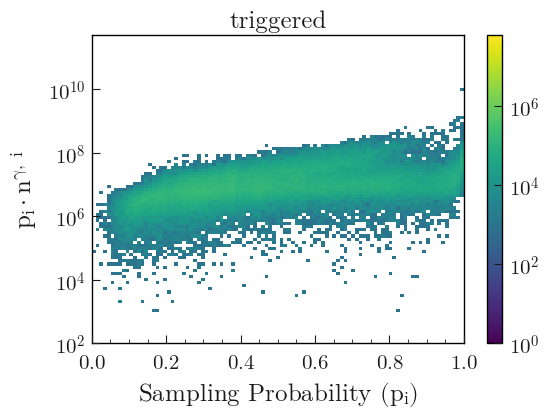

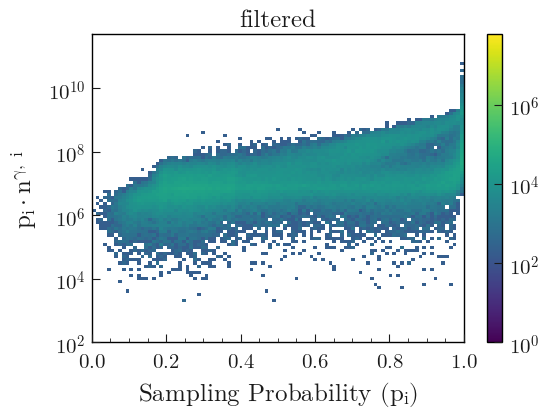

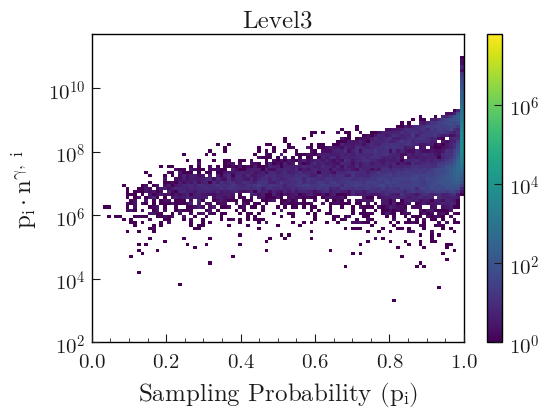

In [72]:
# vals = df[mname]



pred_name = nominal_model

sim_levels = ['generated', 'triggered', 'filtered', 'Level3']
colors = {'generated':'C1', 'triggered':'C2', 'filtered':'C5', 'Level3':'C0'}

vals = df[pred_name] * df['selection_weight'] * df['n_photons']
key = 'sim_level'

hkw = dict(bins=(np.linspace(0,1,100), np.geomspace(1E2,5E11,100) ),  norm='log')

for level in sim_levels:
    fig, ax = plt.subplots()
    mask = df.query(f'sim_level=="{level}"').index

    counts, xedges, yedges, im = ax.hist2d(df[pred_name][mask], (df['n_photons'])[mask], weights=df['selection_weight'][mask], **hkw)
    im.set_clim(1, 6E7)
    ax.set_yscale('log')
    ax.set_xlabel("Sampling Probability ($p_{i}$)")
    ax.set_ylabel("$p_{i} \cdot n^{\gamma,\ i}$")
    cbar = fig.colorbar(im, ax=ax)

    ax.set_title(level)
    ax.set_yscale('log')
    print(np.min( np.where(counts==0, 1E11, counts) ), "%0.2e"%np.max(counts))

i+=1



In [66]:
#"%0.2e"%np.min(counts)
np.min( np.where(counts==0, 1E11, counts) )

1.0

In [46]:
a = ax.hist2d(df[pred_name][mask], (df['n_photons'])[mask], weights=df['selection_weight'][mask], **hkw)

a.set_clim

AttributeError: 'tuple' object has no attribute 'set_clim'

In [59]:
np.max(counts)

9140000.0

In [18]:
# vals = df[mname]

fig, ax = plt.subplots()


pred_name = nominal_model


sim_levels = ['generated', 'triggered', 'filtered', 'Level3']
colors = {'generated':'C1', 'triggered':'C2', 'filtered':'C5', 'Level3':'C0'}


vals = df[pred_name] * df['selection_weight'] * df['n_photons']
# vals = df['gen_weights']
vals = df['sel_gen_weights']  * df['n_photons']
key = 'sim_level'
for level in sim_levels:

    ax.scatter(df['energy_per_nucleon'][mask], vals[mask], s=0.4, alpha=0.1, label=level, color=colors[level])

    ax.set_yscale('log')
    ax.set_xlabel("Primary Energy ($p_{i}$)")
    ax.set_ylabel("$w^{sel.}_{i} \cdot p_{i} \cdot n^{\gamma,\ i}$")
    
ax.set_yscale('log')
ax.set_xscale("log")
#ax.set_title(mname)
ax.legend()
i+=1



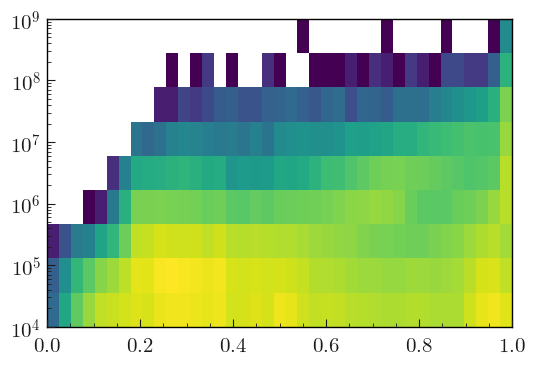

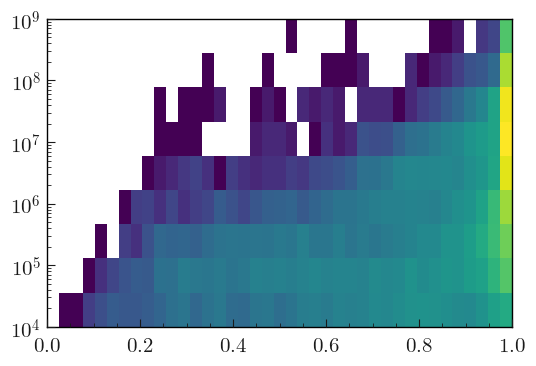

In [109]:
# vals = df[mname]

#fig, ax = plt.subplots()


pred_name = nominal_model


sim_levels = ['generated', 'triggered', 'filtered', 'Level3']
colors = {'generated':'C1', 'triggered':'C2', 'filtered':'C5', 'Level3':'C0'}


vals = df[pred_name] * df['selection_weight'] * df['n_photons']
key  = 'sim_level'


hkw = dict(bins=(np.linspace(0,1,40), np.geomspace(1E4,1E9,10) ),  norm='log')

fig, ax = plt.subplots()
ax.hist2d(df[pred_name][cls0], df['energy'][cls0], **hkw )
ax.set_yscale('log')


fig, ax = plt.subplots()
ax.hist2d(df[pred_name][cls1], df['energy'][cls1], **hkw )
ax.set_yscale('log')



# ax.scatter(df[pred_name][cls0], df['energy'][cls0], s=0.1, alpha=0.1, )
# ax.scatter(df[pred_name][cls1], df['energy'][cls1], s=0.3, alpha=0.4, )

# ax.hist2d(df[pred_name][cls0], df['energy'][cls0], bins=(np.linspace(0,1,40), np.geomspace(1E4,1E9,10) ) )

# ax.set_yscale('log')
# ax.set_xlabel("Sampling Probability ($p_{i}$)")
# ax.set_ylabel("Primary Energy [GeV]")
    
# ax.set_yscale('log')
#ax.set_title(mname)
i+=1



In [ ]:
[k for k in df.columns if 'energy' in k]

In [ ]:
import matplotlib as mpl

colors = {'generated':'C1', 'triggered':'C2', 'filtered':'C5', 'Level3':'C0'}

nplots = len(model_names)
# fig, axs = plt.subplots(nrows=nplots, figsize=(9,15))
# i = 0
for mname in model_names:
    vals = df[mname]
    fig, ax = plt.subplots()
    for t in sim_levels:
        mask = masks[t]
        ax.scatter(vals[mask], vals[mask] * df['selection_weight'][mask] * df['n_photons'][mask], s=0.1, alpha=0.1, label=t, color=colors[t])
        ax.set_yscale('log')
        ax.set_xlabel("Sampling Probability ($p_{i}$)")
        ax.set_ylabel("$w^{sel.}_{i} \cdot p_{i} \cdot n^{\gamma,\ i}$")

    
    ax.set_yscale('log')
    ax.set_title(mname)
    i+=1

# axs[0].legend()


## Model Diagnostics

In [ ]:
#df['log_multiplicity'] = np.log10( df['multiplicity'])
df['log_multiplicity'] = np.log10(df['multiplicity'].replace(0, np.nan))
df = df.fillna(0)
df['log_log_multiplicity'] = np.log10(df['log_multiplicity'].replace(0, np.nan))
df = df.fillna(0)

df_ = df.query("log_rho<6")
for var in mf.features:
    fig, ax = plt.subplots()

    for sim_level in sim_levels:
        mask = df_['sim_level']==sim_level
        #var = 'log_energy'
        #ax.hist(df[mask]['pred'], bins=50, histtype='step', lw=2, label=sim_level)
        d = df_[mask]
        w = combine_weight_columns(d, weight_columns=['weights', 'selection_weight'])
        ax.hist(d[var], weights=w, bins=50, histtype='step', lw=2, label=sim_level)
        
    ax.legend()
    ax.set_xlabel(var)
    ax.set_yscale('log')

#mask